# Сегментация пользователей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('../data/children_products_cleaned.csv')
df.head()

,Дата,ДатаДоставки,МетодДоставки,ФормаОплаты,Регион,Группа2,Группа3,Группа4,Тип,Отменено,Количество,Цена,Статус,Гео,Телефон_new,ID_SKU
0,2017-03-01 12:22:00,2017-03-01 12:22:00,Магазины,Безналичная,Челябинск,"ТЕКСТИЛЬ, ТРИКОТАЖ",ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),боди,ОДЕЖДА,Нет,1,379.0,Доставлен,Регионы,55575453-56535648535679,IDL00028974351
1,2017-03-01 12:31:00,2017-03-01 12:31:00,Магазины,Безналичная,Нижневартовск,ИГРУШКИ,ИГРУШКИ ДЛЯ ДЕВОЧЕК,имитационные игрушки для девочек,ИГРУШКИ,Нет,1,3325.0,Доставлен,Регионы,55574950-57515657535772,IDL00038573351
2,2017-03-01 03:06:00,2017-03-01 03:06:00,Курьерская,Наличная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),ползунки,ОДЕЖДА,Нет,1,330.0,Доставлен,Москва,55574851-55545249535475,IDL00034303856
3,2017-03-01 11:38:00,2017-03-01 11:38:00,Магазины,Безналичная,Ижевск,ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,игрушки для ванной,ИГРУШКИ,Нет,1,199.0,Доставлен,Регионы,55574854-56495552515179,IDL00035791553
4,2017-03-01 12:19:00,2017-03-01 12:19:00,Курьерская,Наличная,Москва,ИГРУШКИ,КОНСТРУКТОРЫ,конструкторы - тип Лего,ИГРУШКИ,Нет,1,719.0,Доставлен,Москва,55574851-53495753545674,IDL00026934452


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470687 entries, 0 to 470686
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Дата           470687 non-null  object 
 1   ДатаДоставки   470687 non-null  object 
 2   МетодДоставки  470687 non-null  object 
 3   ФормаОплаты    470687 non-null  object 
 4   Регион         470687 non-null  object 
 5   Группа2        470687 non-null  object 
 6   Группа3        470687 non-null  object 
 7   Группа4        470687 non-null  object 
 8   Тип            470687 non-null  object 
 9   Отменено       470687 non-null  object 
 10  Количество     470687 non-null  int64  
 11  Цена           470687 non-null  float64
 12  Статус         470687 non-null  object 
 13  Гео            470687 non-null  object 
 14  Телефон_new    470687 non-null  object 
 15  ID_SKU         470687 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 57.5+ MB


In [23]:
print("Количество пропущенных значений в каждом столбце:")
df.isnull().sum()

Количество пропущенных значений в каждом столбце:


Дата             0
ДатаДоставки     0
МетодДоставки    0
ФормаОплаты      0
Регион           0
Группа2          0
Группа3          0
Группа4          0
Тип              0
Отменено         0
Количество       0
Цена             0
Статус           0
Гео              0
Телефон_new      0
ID_SKU           0
dtype: int64

Для сегментации по пользователям необходимо с агрегировать данные. В качестве id клиента - номер телефона.

In [24]:
df['line_revenue'] = df['Цена'] * df['Количество']

customer_features = df.groupby('Телефон_new').agg(
    total_revenue=('line_revenue', 'sum'),
    total_qty=('Количество', 'sum'),
    n_orders_proxy=('ДатаДоставки', 'nunique'),
    n_unique_sku=('ID_SKU', 'nunique'),
    n_group2=('Группа2', 'nunique'),
    n_group3=('Группа3', 'nunique'),
    price_mean=('Цена', 'mean'),
    avg_qty=('Количество', 'mean')
).reset_index()

customer_features['Frequency'] = customer_features['n_orders_proxy']
customer_features['Monetary'] = customer_features['total_revenue']

customer_features['Avg_Price_Per_Item'] = customer_features['price_mean']
customer_features['Revenue_Per_Order_Proxy'] = (
    customer_features['Monetary'] / customer_features['Frequency']
)
customer_features['Items_Per_Order_Proxy'] = (
    customer_features['total_qty'] / customer_features['Frequency']
)

cluster_features = [
    'Frequency', 'Monetary',
    'n_unique_sku', 'n_group2', 'n_group3',
    'Avg_Price_Per_Item',
    'Revenue_Per_Order_Proxy', 'Items_Per_Order_Proxy'
]


In [25]:
q99_mon = customer_features['Monetary'].quantile(0.99)
q99_freq = customer_features['Frequency'].quantile(0.99)

clean_data = customer_features[
    (customer_features['Monetary'] < q99_mon) & 
    (customer_features['Frequency'] < q99_freq)
]

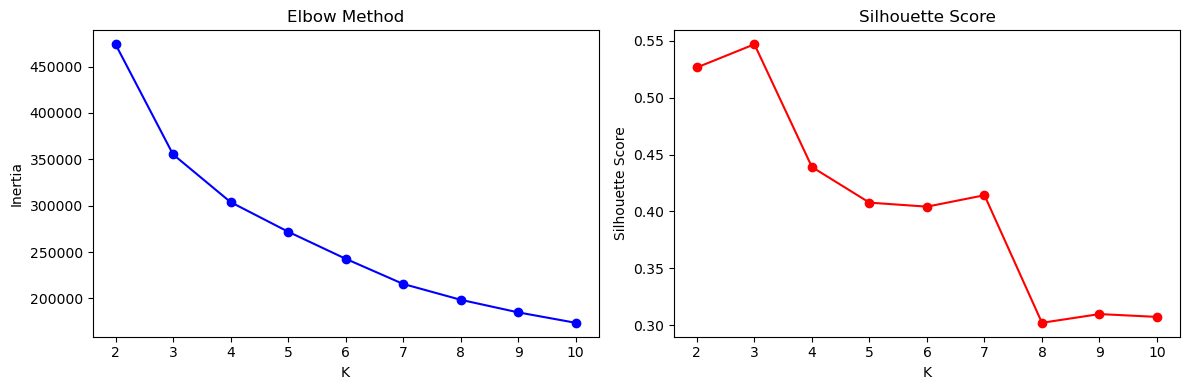

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = clean_data[cluster_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('K')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(k_range, sil_scores, 'ro-')
ax2.set_xlabel('K')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')

plt.tight_layout()
plt.show()


/var/folders/2s/l9p15g5j1t3gkzyssvhh423r0000gn/T/ipykernel_40666/1309256941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['cluster'] = kmeans_final.fit_predict(X_scaled)


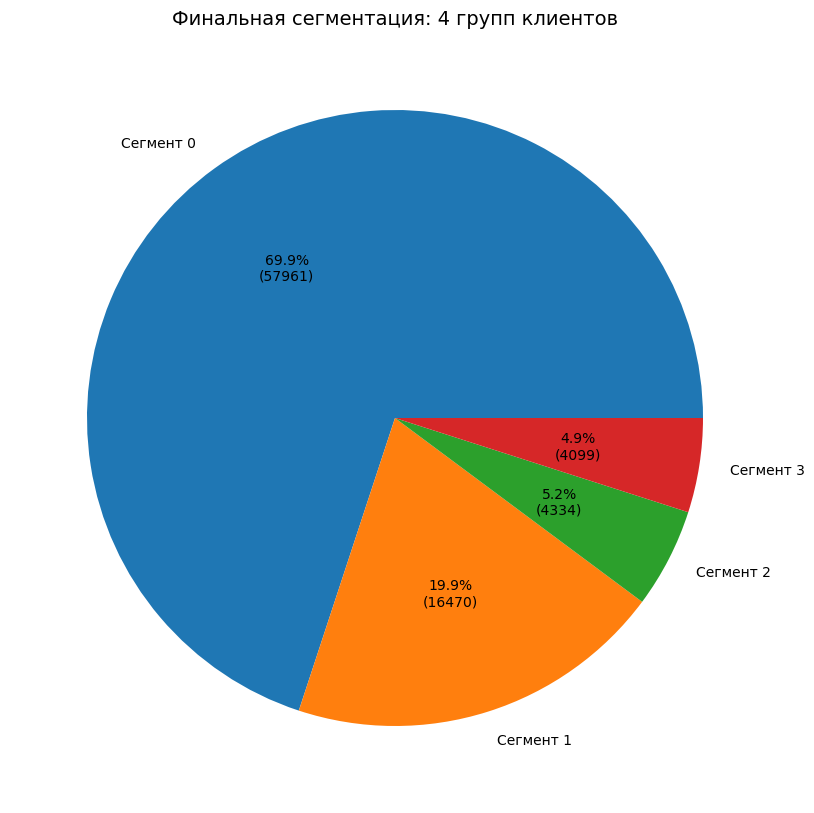

+---+-----------+-------+-------+
| 0 | Сегмент 0 | 57961 | 69.95 |
| 1 | Сегмент 1 | 16470 | 19.88 |
| 2 | Сегмент 2 |  4335 |  5.23 |
| 3 | Сегмент 3 |  4100 |  4.95 |
+---+-----------+-------+-------+


In [39]:
from tabulate import tabulate

final_k = 4
kmeans_final = KMeans(n_clusters=final_k, random_state=7)

clean_data['cluster'] = kmeans_final.fit_predict(X_scaled)

cluster_counts = clean_data['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 10))
plt.pie(
    cluster_counts,
    labels=[f"Сегмент {i}" for i in cluster_counts.index],
    autopct=lambda p: f'{p:.1f}%\n({int(p*len(clean_data)/100)})',
)

plt.title(f'Финальная сегментация: {final_k} групп клиентов', fontsize=14)
plt.show()

summary_table = pd.DataFrame({
    'Сегмент': [f"Сегмент {i}" for i in cluster_counts.index],
    'Количество клиентов': cluster_counts.values,
    'Доля (%)': (cluster_counts.values / len(clean_data) * 100).round(2)
})

print(tabulate(summary_table, tablefmt='psql'))

In [40]:
cluster_profile = clean_data.groupby('cluster')[cluster_features].mean().T

cluster_profile.style.background_gradient(cmap='coolwarm', axis=1).format("{:.2f}")

cluster,0,1,2,3
Frequency,1.07,1.89,1.07,2.14
Monetary,2323.17,5010.92,13118.01,10088.46
n_unique_sku,2.46,8.30,1.80,25.03
n_group2,1.66,3.39,1.30,5.08
n_group3,1.81,4.52,1.42,8.70
Avg_Price_Per_Item,1169.51,574.55,9488.60,315.23
Revenue_Per_Order_Proxy,2204.04,2939.89,12462.76,5420.47
Items_Per_Order_Proxy,3.11,8.49,2.09,32.85
